In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def create_original_dataframe():
    original_df = pd.read_csv('../data/all_financial_with_keywords.csv') 
    original_df = original_df.drop_duplicates()
    return original_df

original_df = create_original_dataframe()

### Prep Target Column
def prep_target_variable(original_df, column='diff'):
    # Convert to percent based deltas
    original_df['open'] = original_df[column] + original_df['close']
    original_df['diff_percent'] = original_df[column] / original_df['close']
    
   # Remove the over 100% change values
    final_df = original_df[(original_df['diff_percent'] > -1.0) & (original_df['diff_percent'] < 1.0)]
    return final_df

original_df = prep_target_variable(original_df)
target_column = 'diff_percent'

### Setup Keyword Column Group and Dataframe
keyword_columns = [
    'technology', 'software', 'ai', 'machine learning', 'cloud', 'saas', 
    'platform', 'digital', 'data', 'analytics', 'algorithm', 'automation', 
    'blockchain', 'cryptocurrency', 'cybersecurity', 'subscription', 'recurring',
    'e-commerce', 'mobile', 'app', 'virtual', 'healthcare', 'biotech', 
    'pharmaceutical', 'medical', 'clinical', 'energy', 'renewable', 'solar', 
    'electric', 'battery', 'real estate', 'logistics', 'transportation', 
    'automotive', 'word_count', 'document_length', target_column
]
keyword_df = original_df[keyword_columns]
keyword_df.head()

,technology,software,ai,machine learning,cloud,saas,platform,digital,data,analytics,...,solar,electric,battery,real estate,logistics,transportation,automotive,word_count,document_length,diff_percent
0,5,2,0,0,1,0,19,3,42,0,...,0,1,0,7,0,0,1,121073,1400564,0.029333
1,26,5,0,0,3,0,4,14,11,0,...,0,0,0,1,0,0,5,89042,1101155,-0.002051
2,26,5,0,0,3,0,4,14,11,0,...,0,0,0,1,0,0,5,89042,1101155,0.000000
3,71,4,0,0,4,0,1,14,144,0,...,0,1,1,7,0,2,0,90097,2325972,0.004995
4,33,9,12,0,2,0,8,4,10,3,...,0,17,2,1,0,29,8,123802,3297190,-0.007323


# Group 2: Keyword Count Data

This is the count of keywords found in a IPO prospectus document.

## Cleaning

Data is not missing any values and all data types are int64, which makes sense for count data. No dupes either.

In [2]:
keyword_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1929 entries, 0 to 2022
Data columns (total 38 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   technology        1929 non-null   int64  
 1   software          1929 non-null   int64  
 2   ai                1929 non-null   int64  
 3   machine learning  1929 non-null   int64  
 4   cloud             1929 non-null   int64  
 5   saas              1929 non-null   int64  
 6   platform          1929 non-null   int64  
 7   digital           1929 non-null   int64  
 8   data              1929 non-null   int64  
 9   analytics         1929 non-null   int64  
 10  algorithm         1929 non-null   int64  
 11  automation        1929 non-null   int64  
 12  blockchain        1929 non-null   int64  
 13  cryptocurrency    1929 non-null   int64  
 14  cybersecurity     1929 non-null   int64  
 15  subscription      1929 non-null   int64  
 16  recurring         1929 non-null   int64  
 17  

## Distribution

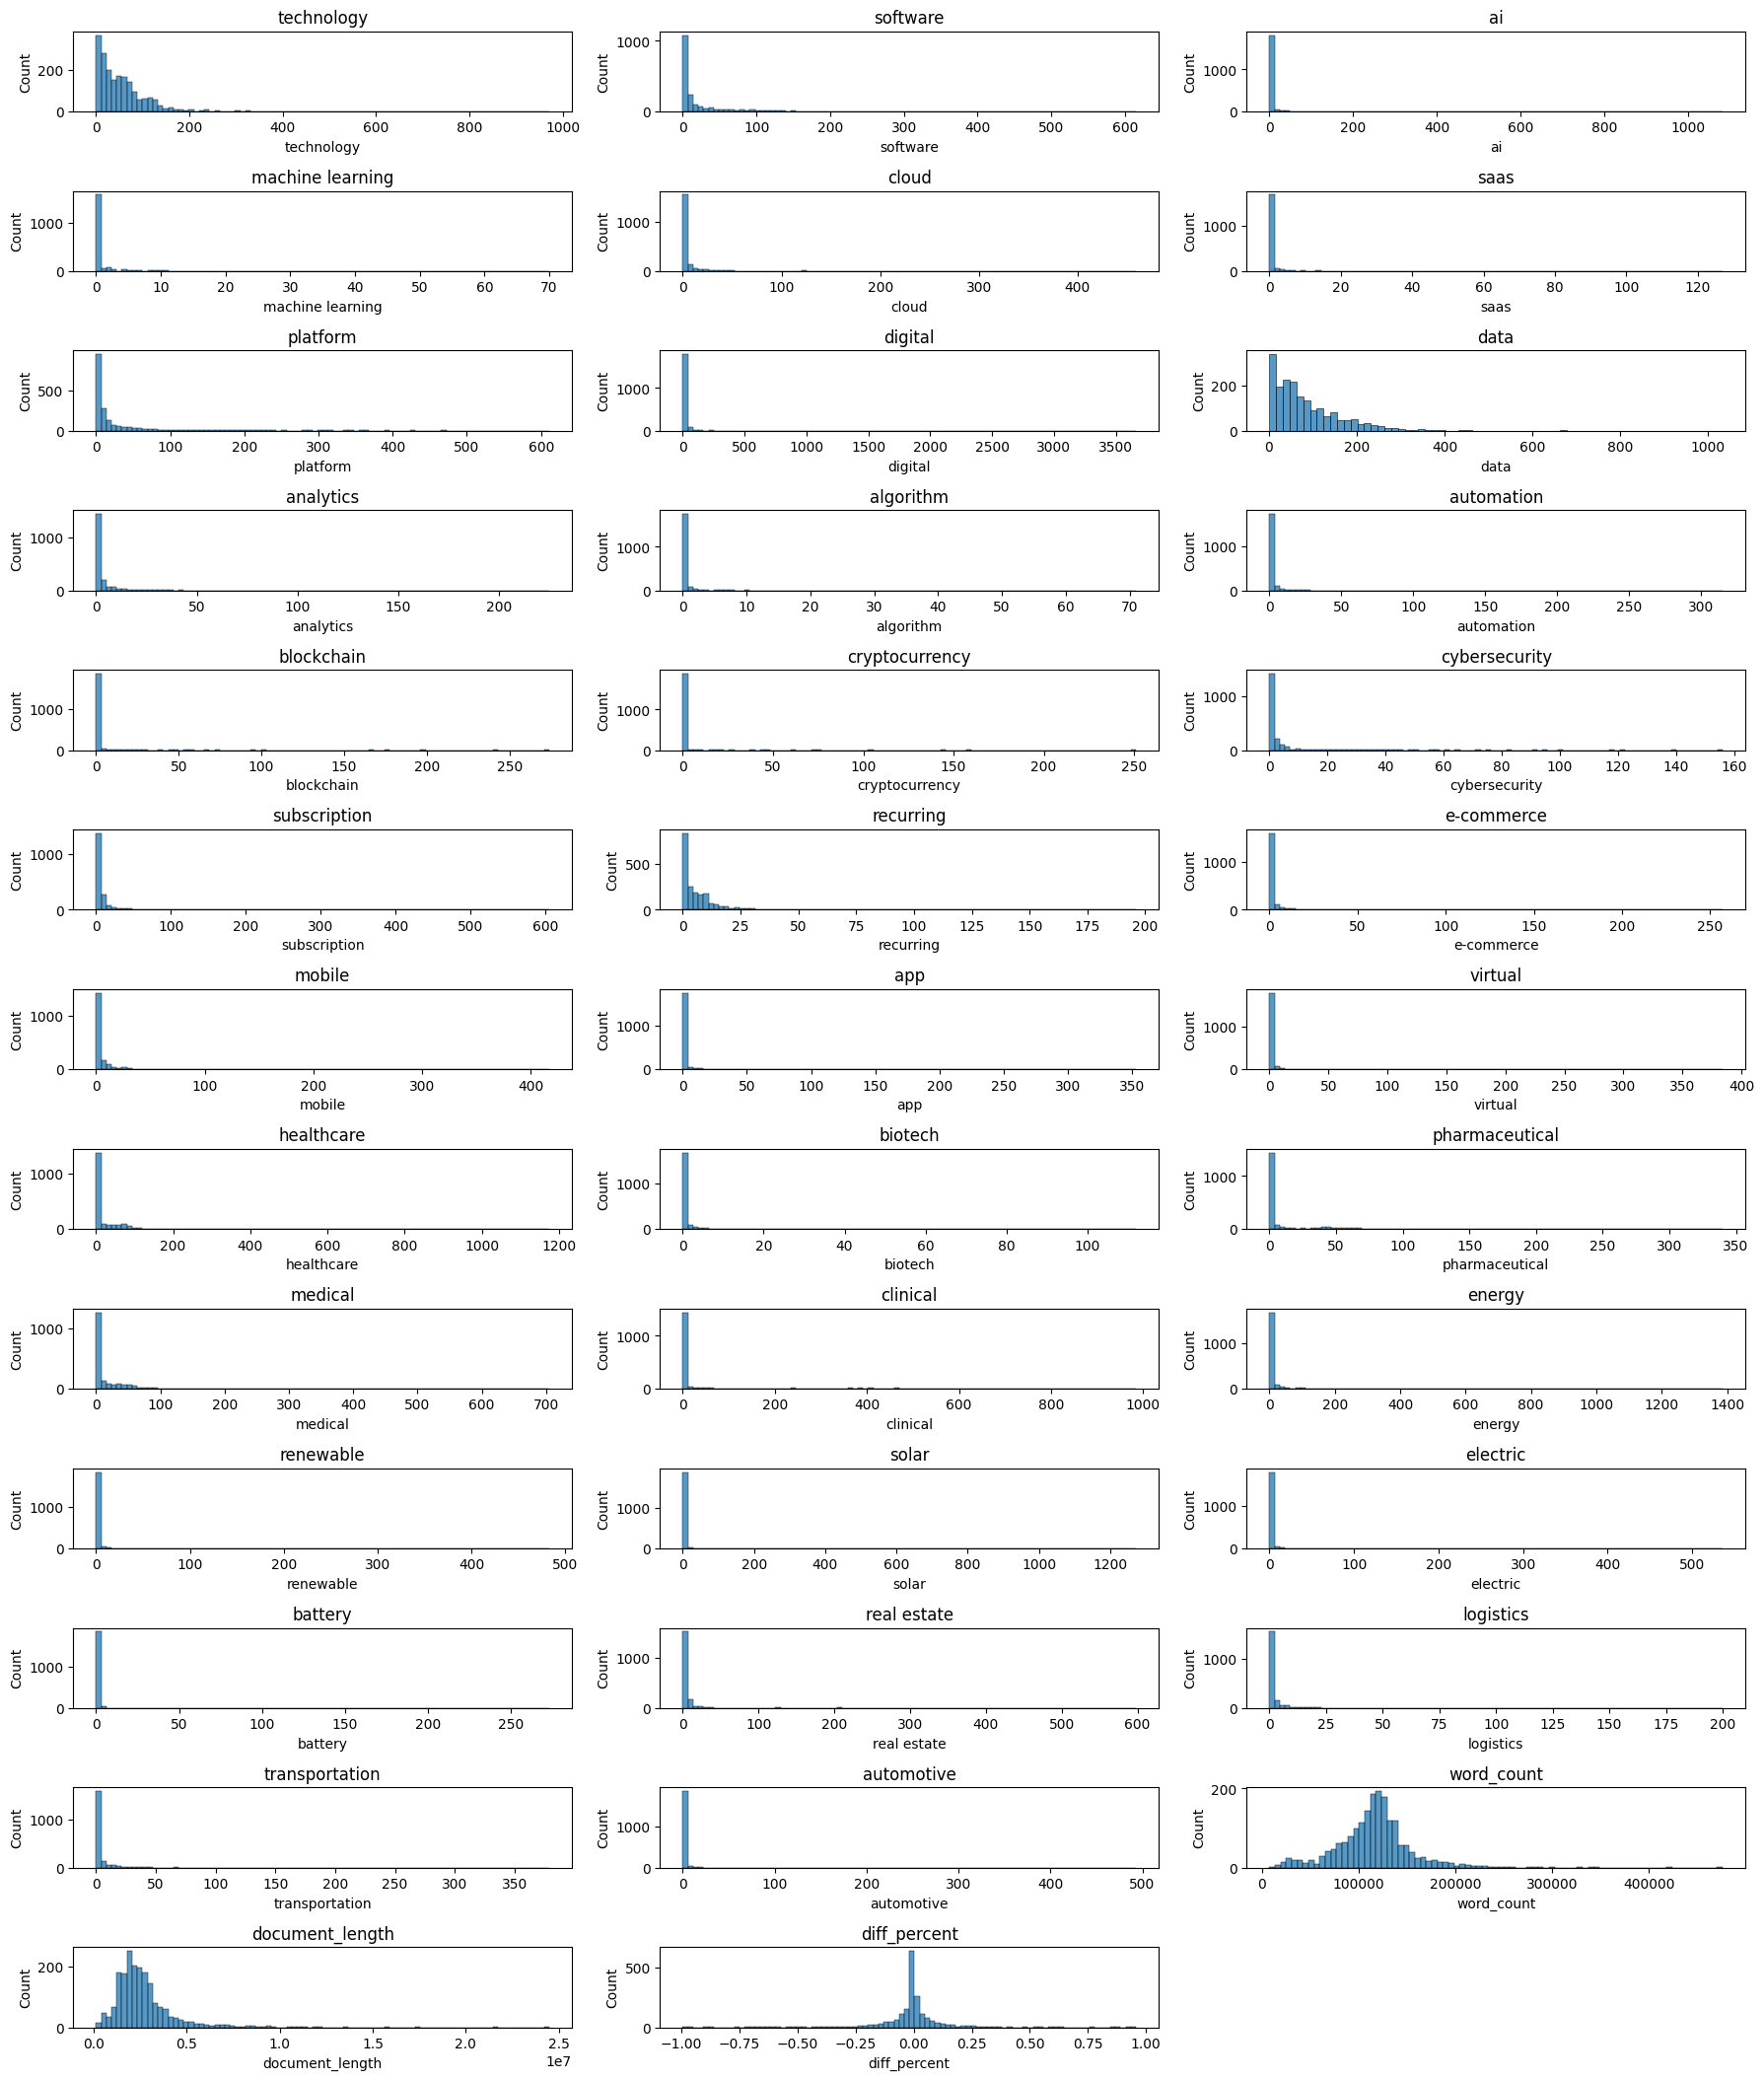

In [3]:
### View Distributions
cols=keyword_df.columns
n = len(cols)

n_rows = 15
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 24))
axes = axes.flatten()

for ax, col in zip(axes, cols):
    sns.histplot(data=keyword_df, x=col, ax=ax)
    ax.set_title(col)

for ax in axes[n:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

In [4]:
### Attempt Poisson Proof

row_list = []

for keyword in keyword_df.columns:
    data = keyword_df[keyword]
    
    mean = data.mean()
    variance = data.var()
    ratio = variance / mean

     # Skip if all zeros or constant
    if data.std() == 0:
        print(f"Skipping {keyword}: No variation in data")
        continue
    
    lambda_param = mean
    alpha = 0.05
    try:
        ks_stat, p_value = stats.kstest(data, 
                                       lambda x: stats.poisson.cdf(x, lambda_param))
    except:
        ks_stat, p_value = np.nan, np.nan
    
    row_list.append({
        'keyword': keyword,
        'positive_ints': all(data >= 0) and all(data == data.astype(int)),
        'mean': mean,
        'variance': variance,
        'ratio': ratio,
        'strong poisson': abs(ratio - 1) < 0.1,
        'overdispersed': ratio > 1.5,
        'underdispersed': ratio < 0.8,
        'ks_stat': ks_stat,
        'p_value': p_value,
        'reject poisson': p_value < alpha
    })
poisson_df = pd.DataFrame(row_list)
print(poisson_df)

print(f"Contains only integers: {all(data == data.astype(int))}")

             keyword  positive_ints          mean      variance         ratio  \
0         technology           True  5.513997e+01  3.164638e+03  5.739282e+01   
1           software           True  2.669103e+01  3.461012e+03  1.296695e+02   
2                 ai           True  4.384655e+00  1.112846e+03  2.538046e+02   
3   machine learning           True  1.064800e+00  1.557827e+01  1.463022e+01   
4              cloud           True  8.285640e+00  1.048860e+03  1.265877e+02   
5               saas           True  1.697252e+00  7.084087e+01  4.173856e+01   
6           platform           True  3.729549e+01  6.117215e+03  1.640202e+02   
7            digital           True  1.817159e+01  1.470019e+04  8.089654e+02   
8               data           True  8.871384e+01  7.571133e+03  8.534331e+01   
9          analytics           True  3.455677e+00  1.237668e+02  3.581552e+01   
10         algorithm           True  3.784344e-01  7.237419e+00  1.912463e+01   
11        automation        

## Feature Scale

Determine if there is a difference between promincence (magnitude) and presence (at least 1 count). This would help determine if the data should be scaled to binary values or use some other method. Given there is not a standard distribution present, and the data is significatly 0 inflated, it is hard to simply apply something such as a log function.

The result concluded that it depened on the bank name. Therefore, leaving the scale as is seems to be the best approach.

In [5]:
count_correlations = keyword_df.corr(method='spearman')[target_column]
count_correlations

technology         -0.011449
software            0.022745
ai                 -0.017280
machine learning    0.001528
cloud               0.017576
saas                0.026695
platform            0.002471
digital            -0.004950
data                0.014304
analytics           0.028905
algorithm          -0.001696
automation          0.007010
blockchain         -0.018644
cryptocurrency     -0.024025
cybersecurity      -0.016941
subscription        0.007703
recurring           0.042751
e-commerce          0.018000
mobile             -0.009739
app                -0.033191
virtual             0.006433
healthcare         -0.006248
biotech            -0.034984
pharmaceutical     -0.049099
medical            -0.017734
clinical           -0.025235
energy             -0.028948
renewable          -0.010036
solar              -0.019317
electric           -0.038116
battery            -0.049092
real estate         0.047832
logistics          -0.006775
transportation     -0.022918
automotive    

In [6]:
binary_mentions = (keyword_df > 0).astype(int)
binary_correlations = binary_mentions.corr(method='spearman')[target_column]
binary_correlations

technology         -0.042881
software            0.020525
ai                  0.013614
machine learning    0.000802
cloud              -0.028912
saas                0.025615
platform            0.030785
digital            -0.006611
data                     NaN
analytics           0.042218
algorithm           0.021921
automation         -0.004492
blockchain         -0.015130
cryptocurrency     -0.026238
cybersecurity      -0.000806
subscription       -0.015835
recurring           0.054146
e-commerce          0.026271
mobile             -0.012820
app                 0.007798
virtual             0.026044
healthcare         -0.026450
biotech            -0.040838
pharmaceutical     -0.046544
medical             0.011601
clinical           -0.027846
energy              0.010808
renewable           0.008962
solar              -0.010534
electric           -0.031277
battery            -0.026225
real estate         0.004602
logistics          -0.003108
transportation      0.000355
automotive    

In [7]:
# Difference between correlations
difference = binary_correlations - count_correlations
performance_retained = binary_correlations / count_correlations

comparison_df = pd.DataFrame({
    'count_corr': count_correlations,
    'binary_corr': binary_correlations,
    'difference': difference,
    'H(0) Accepted': difference != 0,
    'Prominent': difference < 0,
    'Presence': difference > 0
})
comparison_df

,count_corr,binary_corr,difference,H(0) Accepted,Prominent,Presence
technology,-0.011449,-0.042881,-0.031432,True,True,False
software,0.022745,0.020525,-0.002220,True,True,False
ai,-0.017280,0.013614,0.030894,True,False,True
machine learning,0.001528,0.000802,-0.000727,True,True,False
cloud,0.017576,-0.028912,-0.046488,True,True,False
saas,0.026695,0.025615,-0.001080,True,True,False
platform,0.002471,0.030785,0.028314,True,False,True
digital,-0.004950,-0.006611,-0.001661,True,True,False
data,0.014304,NaN,NaN,True,False,False
analytics,0.028905,0.042218,0.013313,True,False,True


## Outliers

Data is has a zero inflated nature, so all values seem like an outlier. Nothing sticks out visualy either, so this will be left alone.

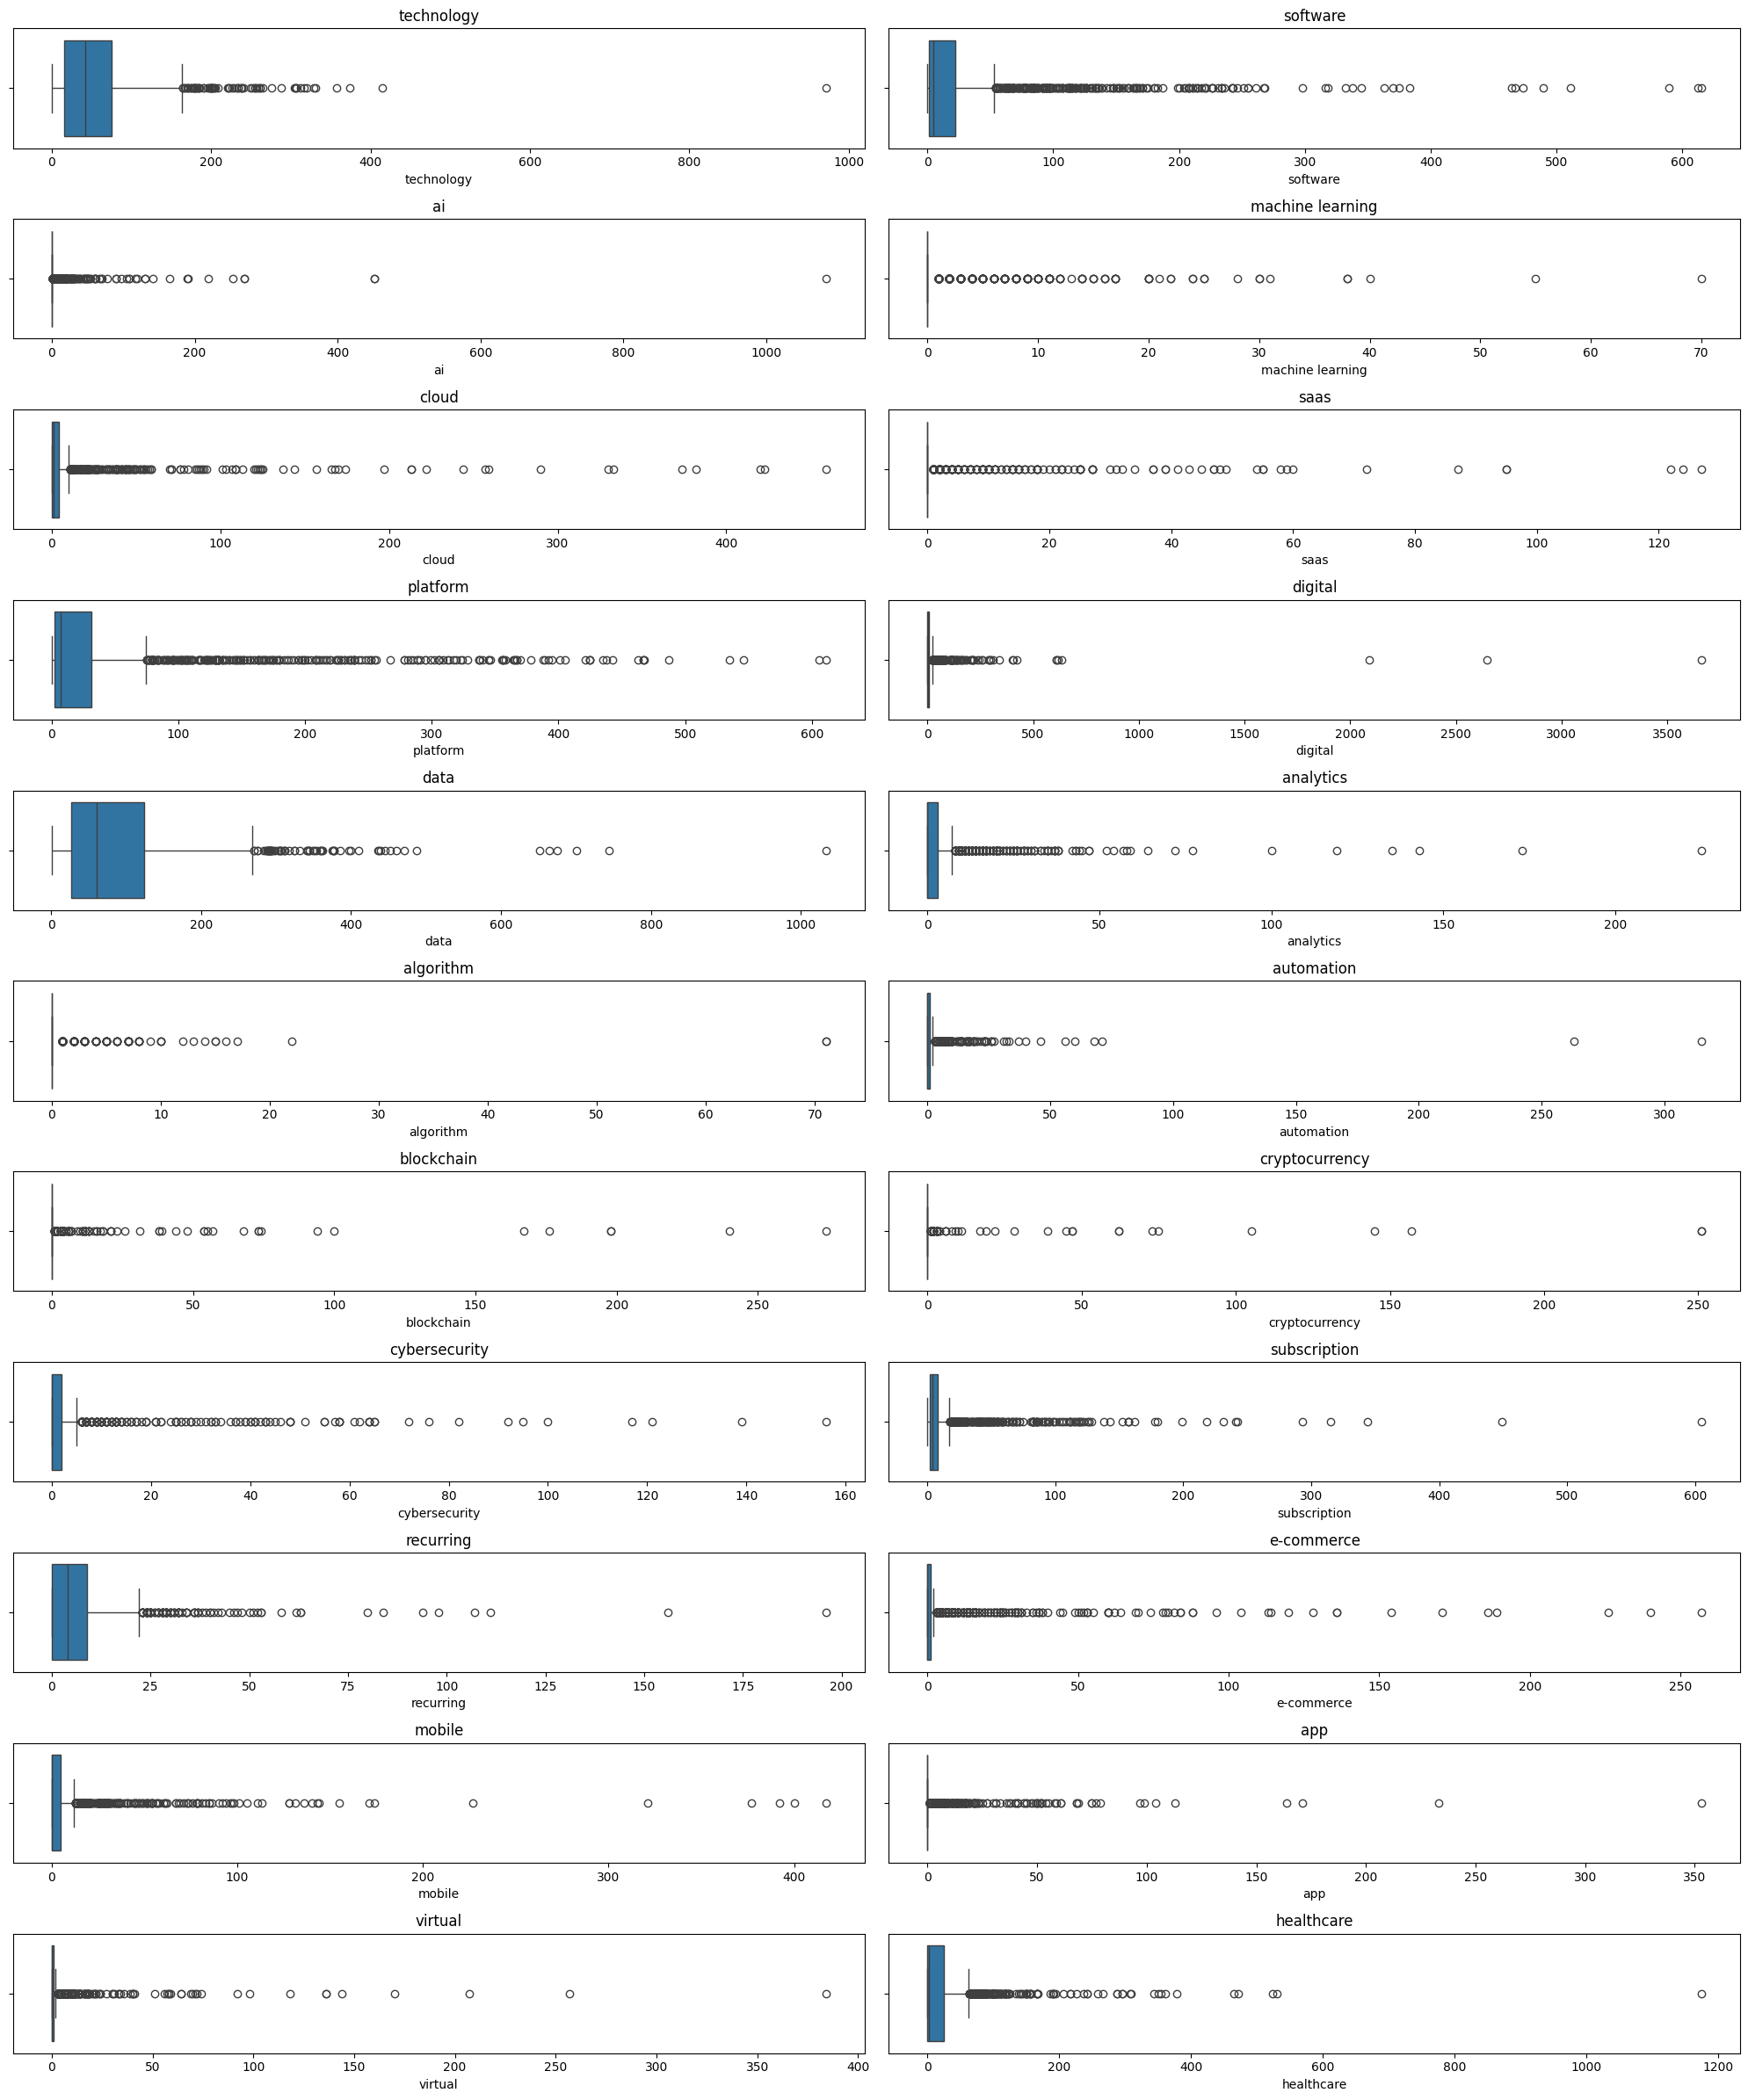

In [8]:
# Create Box Plots
cols=keyword_df.columns
n = len(cols)

n_cols = 2
n_rows = 11

fig, axes = plt.subplots(n_rows, n_cols, figsize=[20,24])
axs = axes.flatten()

for ax, col in zip(axs, cols):
    sns.boxplot(x=keyword_df[col], ax=ax)
    ax.set_title(col)

for ax in axes[n:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

## Feature Engineering

1. Give each keyword a numberical index, and then one hot encode the ones in the row into a group called 'keyword_group'
2. Total banks present in row as 'unique_keyword_count'
3. Add a col/word_count ratio
5. Add a parallel column that transforms to a log1p for stability

In [9]:
### Keyword Group Column
df = keyword_df.drop('diff_percent', axis=1)

### Create a one hot encoding as group
cols = list(df.columns)

df['keyword_group'] = df.apply(lambda row: [col for col, val in row.items() if val >= 1 and col != 'word_count' and col != 'document_length'], axis=1)
df['keyword_group'] = df['keyword_group'].apply(lambda row: [cols.index(keyword) for keyword in row])
print(df['keyword_group'])

0       [0, 1, 4, 6, 7, 8, 14, 15, 16, 24, 26, 29, 31,...
1       [0, 1, 4, 6, 7, 8, 12, 15, 16, 17, 18, 21, 31,...
2       [0, 1, 4, 6, 7, 8, 12, 15, 16, 17, 18, 21, 31,...
3       [0, 1, 4, 6, 7, 8, 11, 15, 16, 20, 26, 27, 29,...
4       [0, 1, 2, 4, 6, 7, 8, 9, 11, 14, 15, 16, 17, 2...
                              ...                        
2018    [0, 1, 4, 5, 6, 7, 8, 9, 11, 14, 15, 16, 17, 1...
2019    [0, 1, 8, 11, 14, 15, 16, 18, 21, 24, 25, 31, 32]
2020    [0, 1, 8, 11, 14, 15, 16, 18, 21, 24, 25, 31, 32]
2021           [0, 8, 15, 16, 18, 21, 24, 25, 26, 31, 33]
2022    [0, 1, 2, 6, 8, 15, 16, 21, 22, 23, 24, 25, 27...
Name: keyword_group, Length: 1929, dtype: object


In [10]:
### Unique Keyword Count Column
df['unique_keyword_count'] = df['keyword_group'].apply(lambda row: len(row))

In [11]:
### Add Word Count Length to Count Ratio

for col in df.columns:
    if col == 'keyword_group' or col == 'word_count' or col == 'document_length' or col == 'unique_keyword_count':
        continue
    new_col = f'{col}-word-count-ratio'
    df[new_col] = df[col]/df['word_count']
print(df.columns)

Index(['technology', 'software', 'ai', 'machine learning', 'cloud', 'saas',
       'platform', 'digital', 'data', 'analytics', 'algorithm', 'automation',
       'blockchain', 'cryptocurrency', 'cybersecurity', 'subscription',
       'recurring', 'e-commerce', 'mobile', 'app', 'virtual', 'healthcare',
       'biotech', 'pharmaceutical', 'medical', 'clinical', 'energy',
       'renewable', 'solar', 'electric', 'battery', 'real estate', 'logistics',
       'transportation', 'automotive', 'word_count', 'document_length',
       'keyword_group', 'unique_keyword_count', 'technology-word-count-ratio',
       'software-word-count-ratio', 'ai-word-count-ratio',
       'machine learning-word-count-ratio', 'cloud-word-count-ratio',
       'saas-word-count-ratio', 'platform-word-count-ratio',
       'digital-word-count-ratio', 'data-word-count-ratio',
       'analytics-word-count-ratio', 'algorithm-word-count-ratio',
       'automation-word-count-ratio', 'blockchain-word-count-ratio',
       'cryp

In [12]:
### Add Parallel Log1p Column For Raw Keyword Counts

for col in df.columns:
    if col == 'keyword_group' or col == 'word_count' or col == 'document_length' or col == 'unique_keyword_count' or 'word-count-ratio' in col:
        continue
    new_col = f'{col}-log1p'
    df[new_col] = np.log1p(df[col])

print(df.columns)

Index(['technology', 'software', 'ai', 'machine learning', 'cloud', 'saas',
       'platform', 'digital', 'data', 'analytics',
       ...
       'clinical-log1p', 'energy-log1p', 'renewable-log1p', 'solar-log1p',
       'electric-log1p', 'battery-log1p', 'real estate-log1p',
       'logistics-log1p', 'transportation-log1p', 'automotive-log1p'],
      dtype='object', length=109)


In [ ]:
### Final Algorithm

def prepare_keyword_count_feature(df):
    ### Convert NA to 0
    keyword_df = df.fillna(0)
        
    ### Feature Engineer Keyword Group Column
    cols = list(keyword_df.columns)
    # Remove non bank name columns, check if column has a value
    keyword_df['keyword_group'] = keyword_df.apply(lambda row: [col for col, val in row.items() if val >= 1 and col != 'word_count' and col != 'document_length'], axis=1)
    # Encoded value of bank name is it's index in the cols list 
    keyword_df['keyword_group'] = keyword_df['keyword_group'].apply(lambda row: [cols.index(bank_name) for bank_name in row])

    ### Feature Engineer Unique Bank Count
    # Count the length of the keyword_groups array, which is the numerical list of columns that have at least one count
    keyword_df['unique_keyword_count'] = keyword_df['keyword_group'].apply(lambda row: len(row))

    ### Feature Engineer Bank Count Ratios
    for col in keyword_df.columns:
        if col == 'keyword_group' or col == 'word_count' or col == 'document_length' or col == 'unique_keyword_count':
            continue
        new_col = f'{col}-word-count-ratio'
        keyword_df[new_col] = keyword_df[col]/df['word_count']

    ### Feature Engineer Parallel Log1p Column
    for col in keyword_df.columns:
        if col == 'keyword_group' or col == 'word_count' or col == 'document_length' or col == 'unique_keyword_count' or 'word-count-ratio' in col:
            continue
        new_col = f'{col}-log1p'
        keyword_df[new_col] = np.log1p(keyword_df[col])   
        

    return keyword_df

keyword_columns = [
    'technology', 'software', 'ai', 'machine learning', 'cloud', 'saas', 
    'platform', 'digital', 'data', 'analytics', 'algorithm', 'automation', 
    'blockchain', 'cryptocurrency', 'cybersecurity', 'subscription', 'recurring',
    'e-commerce', 'mobile', 'app', 'virtual', 'healthcare', 'biotech', 
    'pharmaceutical', 'medical', 'clinical', 'energy', 'renewable', 'solar', 
    'electric', 'battery', 'real estate', 'logistics', 'transportation', 
    'automotive', 'word_count', 'document_length'
]
keyword_df = original_df[keyword_columns]

final_df = prepare_keyword_count_feature(keyword_df)
final_df.columns

Index(['technology', 'software', 'ai', 'machine learning', 'cloud', 'saas',
       'platform', 'digital', 'data', 'analytics',
       ...
       'clinical-log1p', 'energy-log1p', 'renewable-log1p', 'solar-log1p',
       'electric-log1p', 'battery-log1p', 'real estate-log1p',
       'logistics-log1p', 'transportation-log1p', 'automotive-log1p'],
      dtype='object', length=109)